<a href="https://colab.research.google.com/github/ManojChristopherRaj/Recommendation-System/blob/main/2022506038_Manoj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recommendation System 1**


Install and import


In [1]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.3 MB/s eta 0:00:00


Loading Data

In [2]:
# Ratings data.
ratings = tfds.load('movielens/100k-ratings', split="train")
# Features of all the available movies.
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"]
})
movies = movies.map(lambda x: x["movie_title"])
user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

movie_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
movie_titles_vocabulary.adapt(movies)
class MovieLensModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      movie_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.movie_model = movie_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features["user_id"])
    movie_embeddings = self.movie_model(features["movie_title"])

    return self.task(user_embeddings, movie_embeddings)
   # Define user and movie models.
user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64)
])
movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64)
])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)
# Create a retrieval model.
model = MovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train for 3 epochs.
model.fit(ratings.batch(4096), epochs=3)

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title))))

# Get some recommendations.
_, titles = index(np.array(["42"]))
print(f"Top 3 recommendations for user 42: {titles[0, :3]}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.NDJ409_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1682 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-movies/incomplete.00F8IA_0.1.1/movielens-train.tfrecord*...…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-movies/0.1.1. Subsequent calls will reuse this data.


Epoch 1/3
25/25 [==============================] - 19s 698ms/step - factorized_top_k/top_1_categorical_accuracy: 7.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0018 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0450 - factorized_top_k/top_100_categorical_accuracy: 0.1010 - loss: 33067.0778 - regularization_loss: 0.0000e+00 - total_loss: 33067.0778
Epoch 2/3
25/25 [==============================] - 16s 620ms/step - factorized_top_k/top_1_categorical_accuracy: 1.4000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0141 - factorized_top_k/top_50_categorical_accuracy: 0.1046 - factorized_top_k/top_100_categorical_accuracy: 0.2111 - loss: 31015.1252 - regularization_loss: 0.0000e+00 - total_loss: 31015.1252
Epoch 3/3
25/25 [==============================] - 15s 596ms/step - factorized_top_k/top_1_categorical_accuracy: 4.2000e-04 - factorized_top_k/top_5_categor

**Recommendation System 2**

**Two Tower Model**

Unique movie titles: ['Star Kid (1997)', 'Species (1995)', 'Lord of Illusions (1995)', 'Disclosure (1994)', 'Clean Slate (Coup de Torchon) (1981)']
Unique user IDs: ['208', '686', '811', '164', '765']
Number of unique movie titles: 1664
Number of unique user IDs: 943
Epoch 1/10
10/10 [==============================] - 20s 2s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0012 - factorized_top_k/top_10_categorical_accuracy: 0.0045 - factorized_top_k/top_50_categorical_accuracy: 0.0497 - factorized_top_k/top_100_categorical_accuracy: 0.1148 - loss: 69823.5987 - regularization_loss: 0.0000e+00 - total_loss: 69823.5987 - val_factorized_top_k/top_1_categorical_accuracy: 0.0025 - val_factorized_top_k/top_5_categorical_accuracy: 0.0152 - val_factorized_top_k/top_10_categorical_accuracy: 0.0320 - val_factorized_top_k/top_50_categorical_accuracy: 0.1487 - val_factorized_top_k/top_100_categorical_accuracy: 0.2618 - val_loss: 28849.

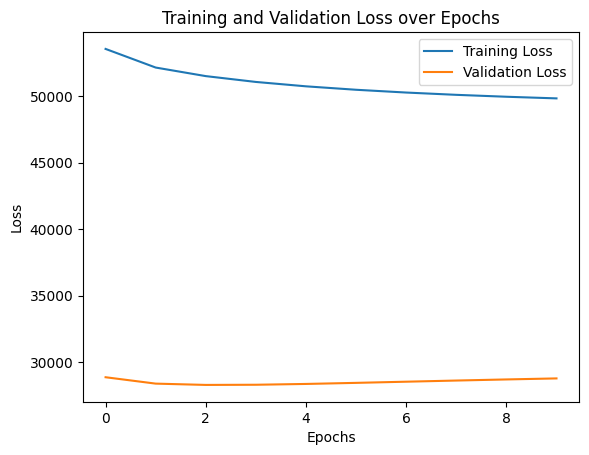

Recommended Movies for User ID 42:
1. Unstrung Heroes (1995)
2. Black Sheep (1996)
3. Rudy (1993)
4. Jack (1996)
5. Only You (1994)
6. In the Army Now (1994)
7. Unforgettable (1996)
8. House Party 3 (1994)
9. Striptease (1996)
10. Rent-a-Kid (1995)
Recommendations for User ID 42 based on past interactions:
1. In the Army Now (1994)
2. House Party 3 (1994)
3. Striptease (1996)
4. Princess Caraboo (1994)
5. It Takes Two (1995)
6. Andre (1994)
7. Angels in the Outfield (1994)
8. Next Karate Kid, The (1994)
9. Legends of the Fall (1994)
10. Happy Gilmore (1996)


In [3]:
# Install required libraries
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = [movie.numpy().decode('utf-8') for movie in movies]
unique_user_ids = [rating['user_id'].numpy().decode('utf-8') for rating in ratings]

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

print("Unique movie titles:", unique_movie_titles[:5])  # Show a few examples
print("Unique user IDs:", unique_user_ids[:5])          # Show a few examples

# Ensure the lengths are correct
print(f"Number of unique movie titles: {len(unique_movie_titles)}")
print(f"Number of unique user IDs: {len(unique_user_ids)}")

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Define the Two-Tower model
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=movies.batch(128).map(movie_model)
            )
        )

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

# Train the model and store the history
history = model.fit(cached_train, epochs=10, validation_data=cached_test)

# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")

def recommend_based_on_preferences(user_id, ratings_data, model, movie_titles, top_k=10):
    rated_movies = [rating['movie_title'].numpy().decode('utf-8') for rating in ratings_data if rating['user_id'].numpy().decode('utf-8') == user_id]
    movie_candidates = [movie for movie in movie_titles if movie not in rated_movies]

    recommended_movies = get_movie_recommendations(user_id, model, movie_candidates, top_k)
    return recommended_movies

# Example: Recommend movies for a user based on past interactions
user_id_preferences_example = "42"  # Replace with a valid user ID
preferences_based_recommendations = recommend_based_on_preferences(user_id_preferences_example, ratings, model, unique_movie_titles)

# Print the recommendations based on user preferences
print(f"Recommendations for User ID {user_id_preferences_example} based on past interactions:")
for idx, movie in enumerate(preferences_based_recommendations, 1):
    print(f"{idx}. {movie}")


**Recommendation System 3**

**Enhanced MovieLens model**

In [5]:
!pip install -q tensorflow-recommenders
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
import numpy as np

# Load the MovieLens dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Prepare the data
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "timestamp": x["timestamp"]
})

movies = movies.map(lambda x: x["movie_title"])

# Define the user and movie model with additional features.
user_ids_vocabulary = tf.keras.layers.StringLookup()
movie_titles_vocabulary = tf.keras.layers.StringLookup()

user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))
movie_titles_vocabulary.adapt(movies)

user_model = tf.keras.Sequential([
    user_ids_vocabulary,
    tf.keras.layers.Embedding(user_ids_vocabulary.vocab_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

movie_model = tf.keras.Sequential([
    movie_titles_vocabulary,
    tf.keras.layers.Embedding(movie_titles_vocabulary.vocab_size(), 64),
    tf.keras.layers.Dense(32, activation="relu")
])

# Define the retrieval task with additional metrics.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    candidates=movies.batch(128).map(movie_model),
    ks=[5, 10]
))

# Define the model.
class EnhancedMovieLensModel(tfrs.Model):
    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        self.task = task

    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, movie_embeddings)

# Create and compile the model.
model = EnhancedMovieLensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))

# Train the model.
model.fit(ratings.batch(4096), epochs=5)

# Set up brute-force search for retrieval.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    movies.batch(100).map(lambda title: (title, model.movie_model(title)))
)

# Get recommendations.
_, titles = index(np.array(["55"]))
print(f"Top 3 recommendations for user 55: {titles[0, :3]}")


Epoch 1/5
25/25 [==============================] - 13s 463ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0069 - loss: 32300.3918 - regularization_loss: 0.0000e+00 - total_loss: 32300.3918
Epoch 2/5
25/25 [==============================] - 8s 299ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0047 - factorized_top_k/top_10_categorical_accuracy: 0.0110 - loss: 31462.1906 - regularization_loss: 0.0000e+00 - total_loss: 31462.1906
Epoch 3/5
25/25 [==============================] - 8s 294ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0142 - loss: 30902.0633 - regularization_loss: 0.0000e+00 - total_loss: 30902.0633
Epoch 4/5
25/25 [==============================] - 6s 248ms/step - factorized_top_k/top_5_categorical_accuracy: 0.0090 - factorized_top_k/top_10_categorical_accuracy: 0.0207 - loss: 30552.9943 - regularization_loss: 0.0000e+00 - total_loss: 30